In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [32]:
df_raw = pd.read_parquet('data/_local/results/global_flows.parquet')

In [35]:
def plot_kde(df, group_col, value_col, title, output_file):
    grouped = df.groupby(group_col)[value_col].sum()
    n = len(grouped)
    stats = {
        "total (bags)": grouped.sum() / 60,
        "median (kg)": grouped.median(),
        "std (kg)": grouped.std(),
        "min (kg)": grouped.min(),
        "max (kg)": grouped.max()
    }
    plt.figure(figsize=(10, 3))
    sns.kdeplot(grouped, fill=True)
    plt.title(f"{title} (n={n:,.0f})")
    plt.xlabel("Values")
    plt.ylabel("Density")

    stats_text = "\n".join([f"{k}: {v:,.0f}" for k, v in stats.items()])
    plt.annotate(stats_text, xy=(0.95, 0.5), xycoords="axes fraction", ha="right", fontsize=10)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

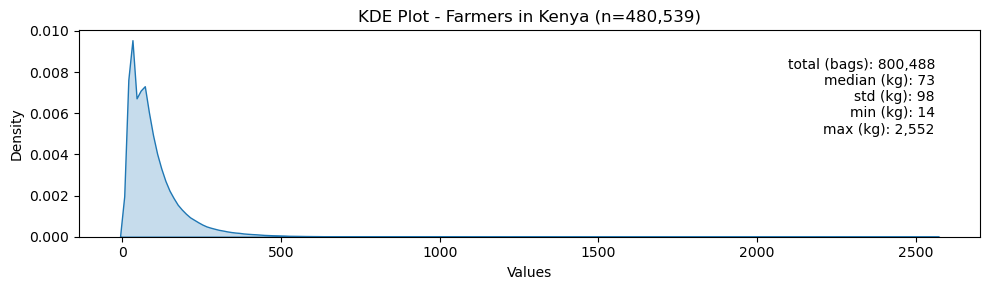

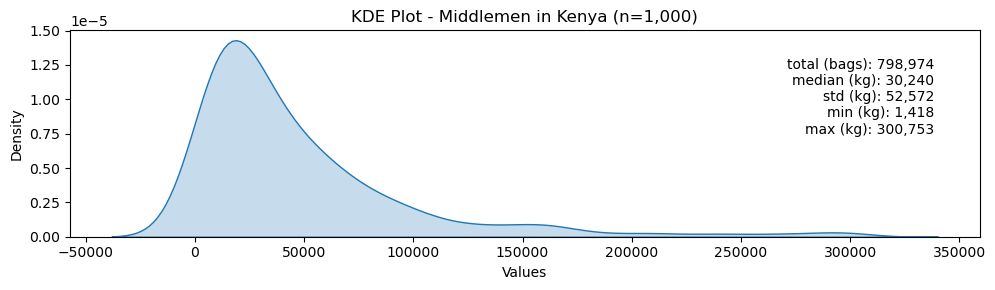

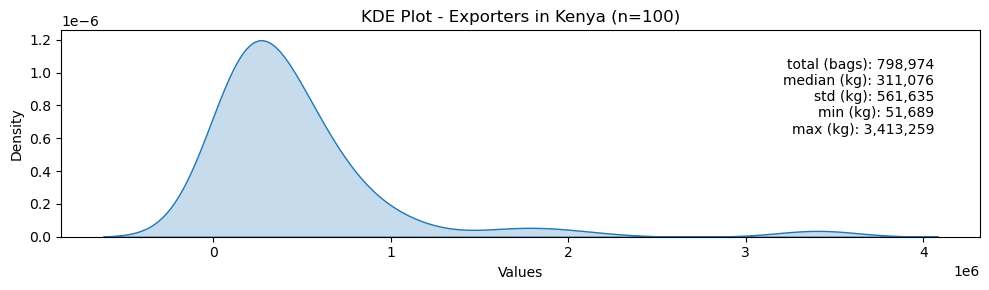

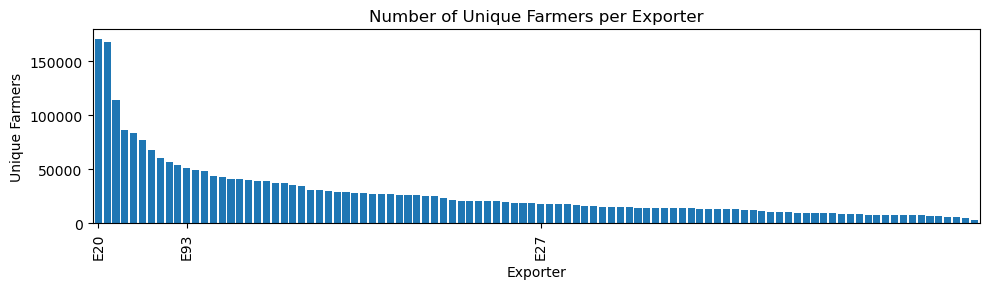

Number of unique farmers across 30 random exporters: 374,746 out of 480,539 total in country.


In [38]:
country = 'Kenya'
country_df = df_raw[df_raw["country"] == country]

farmers_df = country_df[country_df["source"].str.startswith("F")]
num_farmers = farmers_df['source'].nunique()
plot_kde(farmers_df, "source", "value", f"KDE Plot - Farmers in {country}", f"kde_farmers_{country}.png")

middlemen_df = country_df[country_df["source"].str.startswith("M")]
plot_kde(middlemen_df, "source", "value", f"KDE Plot - Middlemen in {country}", f"kde_middlemen_{country}.png")

exporters_df = country_df[country_df["target"].str.startswith("E")]
plot_kde(exporters_df, "target", "value", f"KDE Plot - Exporters in {country}", f"kde_exporters_{country}.png")

middleman_to_farmers = (
    country_df[country_df["source"].str.startswith("F")]
    .groupby("target")["source"]
    .apply(set)
    .to_dict()
)

exporter_to_middlemen = (
    country_df[country_df["source"].str.startswith("M")]
    .groupby("target")["source"]
    .apply(set)
    .to_dict()
)

farmers_per_exporter = {
    exporter: set.union(
        *(middleman_to_farmers.get(middleman, set()) for middleman in middlemen)
    )
    for exporter, middlemen in exporter_to_middlemen.items()
}

farmer_counts = {exporter: len(farmers) for exporter, farmers in farmers_per_exporter.items()}

pd.Series(farmer_counts).sort_values(ascending=False).plot(kind="bar", width=.8, figsize=(10, 3))
plt.title("Number of Unique Farmers per Exporter")
plt.xlabel("Exporter")
plt.xticks([0,10,50])
plt.ylabel("Unique Farmers")
plt.tight_layout()
plt.savefig("unique_farmers_per_exporter.png")
plt.show()

N = 30
random_exporters = random.sample(list(farmers_per_exporter.keys()), min(N, len(farmers_per_exporter)))
random_farmers_union = set.union(*(farmers_per_exporter[exporter] for exporter in random_exporters))

print(f"Number of unique farmers across {N} random exporters: {len(random_farmers_union):,.0f} out of {num_farmers:,.0f} total in country.")